## Linear Regression

Linear Regression is one of the simplest, oldest and more used
methods of data analysis and in many cases is the starting point
when we try to derive a model by fitting a straight line to data.

In its simplest version we have one independent and one depended
variables and we are trying to a find a **linear** relationship
between them that will allow us to make predictions based on unseen
before values.

### A Trivial Case

The data that we will use for this example will be coming
from **Auto Insurance in Sweden** from this [link](https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html)

**Auto Insurance in Sweden**

X = number of claims

Y = total payment for all the claims in thousands of Swedish Kronor

Let's load and plot the data to understand the problem better:




In [88]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


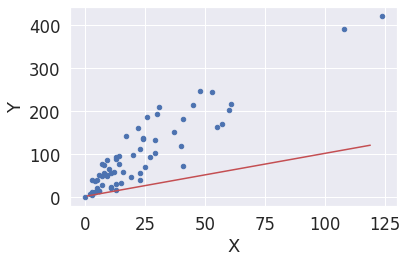

In [90]:
a = 2
b = 1
y = lambda x: a + b * x
X = [i for i in range(1, 120)]
Y = [y(i) for i in range(1, 120)]

df.plot.scatter(x='X', y='Y', colormap='viridis')
_ = plt.plot(X, Y, color='r')

Our objective is to find a straight line that will fit the above
data points as good as possible.

In other words are looking for a line that can be expressed by the following
equation:


$y = a + b \times c$

Note that the random values that we have given to $a$ and $b$ result
to a line that is not very well correlated with our data.

After playing a little with the values we can see the following
are fitting our data much better as we can see from this plot:

Let's give some random values to $a$ and $b$ and visualize how the straight line
looks when compared to the testing data:

### Least Squares Regression Line

The mathematical method to identify the best possible values for
$a$ (**y-intercept**) and $b$ (**slope**) is called **Least Squares
Regression Line**

An informal definition of the **Least Squares Line** is that it is the line
that given a set of points in the plane it minimizes the sum of distances
from them.



In [108]:
def make_dummy_data(func, x1=0, x2=100, count=10, mu=0, sigma=65):
    x_values = np.random.uniform(low=x1, high=x2, size=(count,))
    noise = np.random.normal(mu, sigma, count)
    y_values = []
    for index, x in enumerate(x_values):
        y = func(x)
        noisy_value = y + noise[index]
        y_values.append(noisy_value)
    return x_values, y_values

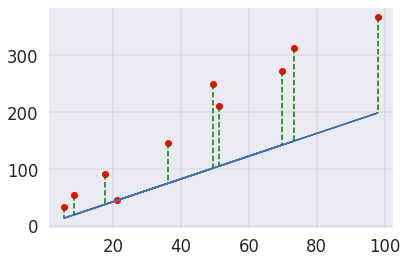

In [144]:
func = lambda x: 5 + 3.2 * x
x_values, y_values = make_dummy_data(func=func, count=10)
plt.scatter(x_values, y_values, color="red")

# Pick a random line.
func_1 = lambda x: 2.6 + 2.0 * x

y_1 = [func_1(x) for x in x_values]
plt.plot(x_values, y_1, color='b')

# Print the distances from the points
delta_y = []

for index in range(len(x_values)):
    x = x_values[index]
    plt.plot([x,  x] , [y_values[index], func_1(x)] , color='green', linestyle='dashed',)
    delta_y.append((x, y_values[index] - func_1(x)))
    
plt.grid(color='gray', linestyle='-', linewidth=0.2)

delta_y.sort(key= lambda p: p[0])
df = pd.DataFrame(delta_y, columns = ['x', 'DY'])
df['DYSquared'] = df.apply(lambda row: row["DY"]**2, axis=1)
squares_sum =  df['DYSquared'].sum()     

In [145]:
def solve_linear_regression(x, y):
    """Finds the Least Square line.
    
    :param np.array | list x: The independed values.
    :param np.array | list y: The depended values.
    
    :returns: The linear function that will make predictions 
    for the passed in x value.
    
    :rtype: callable.
    """
    if isinstance(x, list):
        x = np.array(x)
        
    if isinstance(y, list):
        y = np.array(y)
        
    assert x.size == y.size
    
    n = x.size
    A = np.sum(np.square(x))
    B = np.sum(x)
    C = np.sum(x*y)
    D = np.sum(y)
    
    assert B**2 - A* n != 0
    assert B != 0
    
    b = (C * B - A * D) / (B**2 - A* n)
    a = (D - n * b) / B
    
    print (a, b)
    
    return lambda x: a*x +b 

3.1970411171401913 20.191359073423968


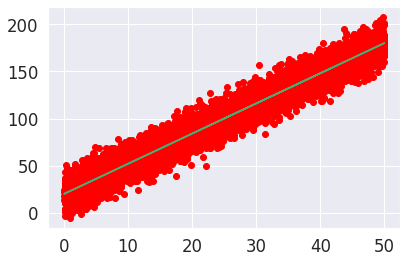

In [146]:
func = lambda x:3.2 * x + 20
x_values, y_values = make_dummy_data(func=func,  x1=0, x2=50, mu=0, sigma=10,  count=10000)
plt.scatter(x_values, y_values, color="red")
foo =  solve_linear_regression(x_values, y_values)

_ = plt.plot(x_values, foo(x_values), color='b')
_ = plt.plot(x_values, func(x_values), color='g')

### Proof

We are given a set of $x$ and $y$ and we start with the assumption that there
exists a linear function that can connect them, in a more formal language what
we are given and what we will try to discover is a function like the following:

we are given an array of $x_i$  and $y_i$values

and we try to find $a$ and $b$ to fit the distribution:

$y = ax + b$

For each $x_i$ that we are given the error that the abobe line will have when
calculating the corresponding y value will be given from the following formula:

$E_i = y_i - (ax_i + b) $

to avoid negative values the common practice will be to square the error as can be seen here:

$E_i = (y_i - (ax_i + b)) ^2 $

which can be written as follows for the cumulative error of the available data:

$E=\sum_{k=1}^n (y_i - (ax_i + b)) ^2$

Since we are trying to minimize E, meaning to find the values of $a$, $b$ that will
make the expression minimum, we can try to find the derivative of the expression and
find what value will make it zero.  Since we have two unknowns we will need to find the 
values that will make the corresponding partial derivatives equal to zero:

$\Large \frac{\partial E} {\partial a} = 0$


$\Large \frac{\partial E} {\partial b} = 0$

________________
Let's set:
$\Large u = ax_i + b $ 

so 

$\Large \frac{\partial u} {\partial a} = x_i$ and $\Large \frac{\partial u} {\partial b} = 1$

The rest of the proof can be seen the following images:


![simple-linear-regression-1](simple-linear-regression-1.jpg)
![simple-linear-regression-2](simple-linear-regression-2.jpg)


### Closed Solution 

The solution we have given above to the problem of Linear Regression is called a **closed formula** meaning that we can apply an single function and calculate the line. 

We will see another way that we can follow fo solve the least squares which will contain all the steps (albeit simpler) that we will use in many other methods on machine learning. 


### The  four assumptions of applying a linear regression model

| Name      | Description |
| ----------- | ----------- |
| Linearity      | The relationship between X and the mean of Y is linear       |
| Homoscedasticity   | The variance of residual is the same for any value of X |
|Independence |Observations are independent of each other.|
|Normality|For any fixed value of X, Y is normally distributed.|


